In [27]:
import cudf, cuml, cupy
print('RAPIDS',cuml.__version__)
import pandas as pd, numpy as np

import matplotlib.pyplot as plt

import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split

from sklearn.metrics import (
    accuracy_score,
    precision_score, recall_score, f1_score,
    jaccard_score, classification_report
)

def mkdir(directory):
    try: os.mkdir(directory)
    except Exception as e: print(e)

mkdir("logs")
mkdir("models")

RAPIDS 21.10.02
[Errno 17] File exists: 'logs'
[Errno 17] File exists: 'models'


In [28]:
tf.config.run_functions_eagerly(True)
tf.compat.v1.enable_eager_execution()

In [32]:
df = pd.read_csv('/kaggle/input/daphnet-freezes/findex.csv')
print('train shape is', df.shape)
df

train shape is (688992, 4)


,freezeX,freezeY,freezeZ,label
0,11.901779,0.0,0.000000,0
1,11.862690,0.0,0.000000,0
2,11.965667,0.0,0.000000,0
3,12.110931,0.0,0.000000,0
4,12.198498,0.0,0.000000,0
...,...,...,...,...
688987,0.000000,0.0,0.539964,0
688988,0.000000,0.0,0.967602,0
688989,0.000000,0.0,1.233355,0
688990,0.000000,0.0,1.507971,0


In [38]:
X = df.iloc[:, :-1].values
X

array([[11.90177873,  0.        ,  0.        ],
       [11.86269024,  0.        ,  0.        ],
       [11.96566721,  0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  1.23335459],
       [ 0.        ,  0.        ,  1.50797064],
       [ 0.        ,  0.        ,  1.76433284]])

In [39]:
y = df.label.values
y

array([0, 0, 0, ..., 0, 0, 0])

In [40]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.2, random_state=123)
X_val, X_test, y_val, y_test = train_test_split(X, y, test_size=0.5, random_state=123)

In [41]:
def build_model(
    size = 1024,
    activation = tf.nn.swish,
    optimizer = keras.optimizers.Adam,
    lr = 1e-4,
):
    model = keras.Sequential([
        layers.Dense(size, activation=activation, input_shape=(3,)),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=optimizer(learning_rate=lr),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=["accuracy", "Precision", "Recall"]
    )
    
    return model

In [45]:
def train_fit_model(model, model_name):
    mkdir(f"logs/{model_name}/")
    mkdir(f"models/{model_name}/")
    
    history = model.fit(
        x = X_train, y=y_train, validation_data=(X_val, y_val), 
        epochs=20, validation_steps=100,
        steps_per_epoch=100
    )
    
    model.save_weights(f"models/{model_name}/model.h5")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 16))
    
    for i, metric in enumerate(list(history.history.keys())[:4]):
        axes[i // 2, i % 2].plot(history.history[metric], label="Training")
        axes[i // 2, i % 2].plot(history.history["val_"+metric], label="Validation")    
        axes[i // 2, i % 2].set_title(metric.split("_")[0].title())
        axes[i // 2, i % 2].legend()
    
    plt.savefig(f"logs/{model_name}/plot.png")
    plt.show()
    
    curves = pd.DataFrame(history.history)
    curves.to_csv(f"logs/{model_name}/curves.csv", index = False)
    
    h_test = model.predict(X_test).round().flatten()
    
    # Compile Values into a Series Object for easy display
    values = pd.Series({
        "Accuracy":accuracy_score(y_test, h_test),
        "Precision":precision_score(y_test, h_test),
        "Recall":recall_score(y_test, h_test),
        "F1 Score":f1_score(y_test, h_test),
        "Jaccard Score":jaccard_score(y_test, h_test),
    })
    
    report = pd.DataFrame(classification_report(y_test, h_test, output_dict=True)).T
    
    report.to_csv(f"logs/{model_name}/report.csv")
    return values

In [ ]:
train_fit_model(build_model(1024,"swish", keras.optimizers.Adam, 1e-4), "1024_swish_adam_1e-4")

[Errno 17] File exists: 'logs/1024_swish_adam_1e-4/'
[Errno 17] File exists: 'models/1024_swish_adam_1e-4/'
Epoch 1/20
  4/100 [>.............................] - ETA: 2s - loss: 0.7097 - accuracy: 0.1804 - precision_6: 0.1433 - recall_6: 0.8810

/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


100/100 [==============================] - 5s 48ms/step - loss: 0.6247 - accuracy: 0.8037 - precision_6: 0.2154 - recall_6: 0.0990 - val_loss: 0.5635 - val_accuracy: 0.8473 - val_precision_6: 0.6033 - val_recall_6: 0.0489
Epoch 2/20
100/100 [==============================] - 4s 36ms/step - loss: 0.5288 - accuracy: 0.8491 - precision_6: 0.6648 - recall_6: 0.0606 - val_loss: 0.4999 - val_accuracy: 0.8514 - val_precision_6: 0.6991 - val_recall_6: 0.0758
Epoch 3/20
100/100 [==============================] - 4s 38ms/step - loss: 0.4806 - accuracy: 0.8524 - precision_6: 0.6956 - recall_6: 0.0910 - val_loss: 0.4635 - val_accuracy: 0.8535 - val_precision_6: 0.6869 - val_recall_6: 0.1041
Epoch 4/20
100/100 [==============================] - 5s 47ms/step - loss: 0.4508 - accuracy: 0.8536 - precision_6: 0.6777 - recall_6: 0.1132 - val_loss: 0.4387 - val_accuracy: 0.8542 - val_precision_6: 0.6695 - val_recall_6: 0.1208
Epoch 5/20
100/100 [==============================] - 5s 47ms/step - loss: 0.42

Epoch 1/20
  4/100 [>.............................] - ETA: 1s - loss: 0.7049 - accuracy: 0.3150 - precision_3: 0.1044 - recall_3: 0.4434

/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


100/100 [==============================] - 3s 34ms/step - loss: 0.6213 - accuracy: 0.8234 - precision_3: 0.2106 - recall_3: 0.0492 - val_loss: 0.5591 - val_accuracy: 0.8480 - val_precision_3: 0.6300 - val_recall_3: 0.0526
Epoch 2/20
100/100 [==============================] - 5s 46ms/step - loss: 0.5250 - accuracy: 0.8495 - precision_3: 0.6665 - recall_3: 0.0653 - val_loss: 0.4970 - val_accuracy: 0.8520 - val_precision_3: 0.6988 - val_recall_3: 0.0827
Epoch 3/20
100/100 [==============================] - 3s 35ms/step - loss: 0.4783 - accuracy: 0.8527 - precision_3: 0.6933 - recall_3: 0.0955 - val_loss: 0.4614 - val_accuracy: 0.8539 - val_precision_3: 0.6804 - val_recall_3: 0.1115
Epoch 4/20
100/100 [==============================] - 5s 46ms/step - loss: 0.4488 - accuracy: 0.8538 - precision_3: 0.6697 - recall_3: 0.1195 - val_loss: 0.4368 - val_accuracy: 0.8541 - val_precision_3: 0.6624 - val_recall_3: 0.1243
Epoch 5/20
100/100 [==============================] - 3s 35ms/step - loss: 0.42

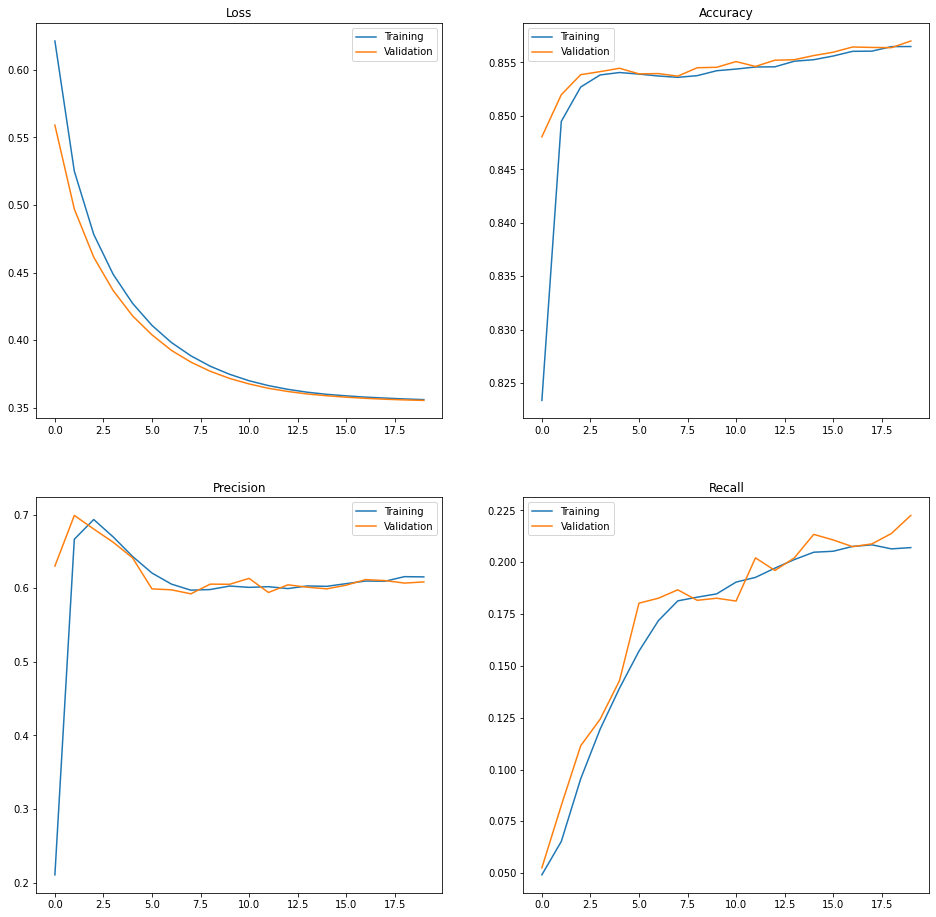

Accuracy         0.855545
Precision        0.611068
Recall           0.219307
F1 Score         0.322773
Jaccard Score    0.192444
dtype: float64


,precision,recall,f1-score,support
0,0.870140,0.974010,0.919150,290421.000000
1,0.611068,0.219307,0.322773,54075.000000
accuracy,0.855545,0.855545,0.855545,0.855545
macro avg,0.740604,0.596658,0.620961,344496.000000
weighted avg,0.829474,0.855545,0.825538,344496.000000


In [24]:
m1, c1, v1, r1 = train_fit_model(
    keras.Sequential([
        layers.Dense(1024, activation=tf.nn.swish, input_shape=(3,)),
        layers.Dense(1, activation='sigmoid')
    ])
)
r1

In [42]:
c1

,loss,accuracy,precision_3,recall_3,val_loss,val_accuracy,val_precision_3,val_recall_3
0,0.621327,0.823383,0.210605,0.049185,0.559081,0.848048,0.630011,0.052572
1,0.525046,0.849488,0.666468,0.065288,0.497040,0.851984,0.698847,0.082661
2,0.478286,0.852703,0.693290,0.095548,0.461403,0.853859,0.680392,0.111479
3,0.448756,0.853833,0.669695,0.119464,0.436751,0.854143,0.662449,0.124262
4,0.427258,0.854060,0.643153,0.139276,0.417971,0.854457,0.641187,0.142969
5,0.410946,0.853913,0.620578,0.157117,0.403949,0.853934,0.599019,0.180272
6,0.398284,0.853735,0.605572,0.171832,0.392473,0.853961,0.597798,0.182664
7,0.388462,0.853608,0.597297,0.181394,0.383805,0.853720,0.592340,0.186720
8,0.380740,0.853768,0.598172,0.183167,0.377004,0.854509,0.605494,0.181655
9,0.374753,0.854227,0.602915,0.184752,0.371699,0.854550,0.605314,0.182664


In [12]:
def train(model):
    model.fit(X_train, y_train)
    h_test = model.predict(X_test)
    accuracy = cuml.metrics.accuracy.accuracy_score(y_test, h_test)
    mat = cuml.metrics.confusion_matrix(y_test, h_test)
    tn, fp, fn, tp = mat.ravel()
    roc_auc = cuml.metrics.roc_auc_score(y_test, h_test)
    sensitivity = recall = tp / (tp+fn)
    specificity = recall = tn / (tn+fp)
    precision = tp / (tp + fp)
    del h_test
    return dict(
        accuracy = accuracy,
        tn = tn,
        fp = fp,
        fn = fn,
        tp = tp,
        roc_auc = roc_auc,
        sensitivity = sensitivity,
        specificity = specificity,
        precision = precision
    )

In [13]:
lr = cuml.linear_model.LogisticRegression()
cudf.DataFrame(train(lr))

,accuracy,tn,fp,fn,tp,roc_auc,sensitivity,specificity,precision
0,0.847725,287106,3315,49143,4932,0.539896,0.091207,0.988586,0.598036


In [11]:
linsvm = cuml.svm.SVC(kernel="linear")
cudf.DataFrame(train(linsvm))

,accuracy,tn,fp,fn,tp,roc_auc,sensitivity,specificity,precision
0,0.844526,116279,52,21372,95,0.501989,0.004425,0.999553,0.646259


In [8]:
svm = cuml.svm.SVC()
cudf.DataFrame(train(svm))

,accuracy,tn,fp,fn,tp,roc_auc,sensitivity,specificity,precision
0,0.860767,114649,1682,17504,3963,0.585075,0.184609,0.985541,0.702037


In [9]:
knn = cuml.neighbors.KNeighborsClassifier(n_neighbors=55)
cudf.DataFrame(train(knn))

,accuracy,tn,fp,fn,tp,roc_auc,sensitivity,specificity,precision
0,0.88137,112500,3831,12516,8951,0.692017,0.416966,0.967068,0.700282


In [12]:
knn = cuml.neighbors.KNeighborsClassifier(n_neighbors=5)
cudf.DataFrame(train(knn))

,accuracy,tn,fp,fn,tp,roc_auc,sensitivity,specificity,precision
0,0.90161,111356,4975,8583,12884,0.778706,0.600177,0.957234,0.721429


In [28]:
knn_df = pd.DataFrame({
    n: train(cuml.neighbors.KNeighborsClassifier(n_neighbors=n))
    for n in range(1, 101)
}).T
knn_df

,accuracy,tn,fp,fn,tp,roc_auc,sensitivity,specificity,precision
1,0.886087,108472,7859,7838,13629,0.783662,0.6348814459402804,0.9324427710584453,0.6342609828741623
2,0.900644,113458,2873,10818,10649,0.735683,0.49606372571854473,0.9753032295776706,0.7875314302617956
3,0.89952,110634,5697,8149,13318,0.785711,0.6203940932594214,0.9510276710421126,0.7003944254535893
4,0.902771,113107,3224,10174,11293,0.749175,0.5260632598872689,0.9722859770826349,0.7779155472893848
5,0.90161,111356,4975,8583,12884,0.778706,0.6001770158848465,0.9572340992512743,0.7214289713869757
...,...,...,...,...,...,...,...,...,...
96,0.875775,112757,3574,13544,7923,0.669178,0.3690781199049704,0.9692773207485537,0.6891362964251544
97,0.875956,112644,3687,13406,8061,0.671906,0.37550659151255417,0.9683059545606932,0.6861593462717058
98,0.875825,112767,3564,13547,7920,0.669151,0.36893837052219686,0.9693632823580989,0.6896551724137931
99,0.875535,112618,3713,13438,8029,0.671049,0.3740159314296362,0.9680824543758757,0.6837847044796457


In [58]:
knn_df.sort_values(["accuracy"], ascending=False).head(3).round(3)

,accuracy,tn,fp,fn,tp,roc_auc,sensitivity,specificity,precision
4,0.902771,113107,3224,10174,11293,0.749175,0.5260632598872689,0.9722859770826349,0.7779155472893848
6,0.902154,112949,3382,10101,11366,0.750196,0.5294638282014255,0.9709277836518211,0.7706807702739354
5,0.90161,111356,4975,8583,12884,0.778706,0.6001770158848465,0.9572340992512743,0.7214289713869757


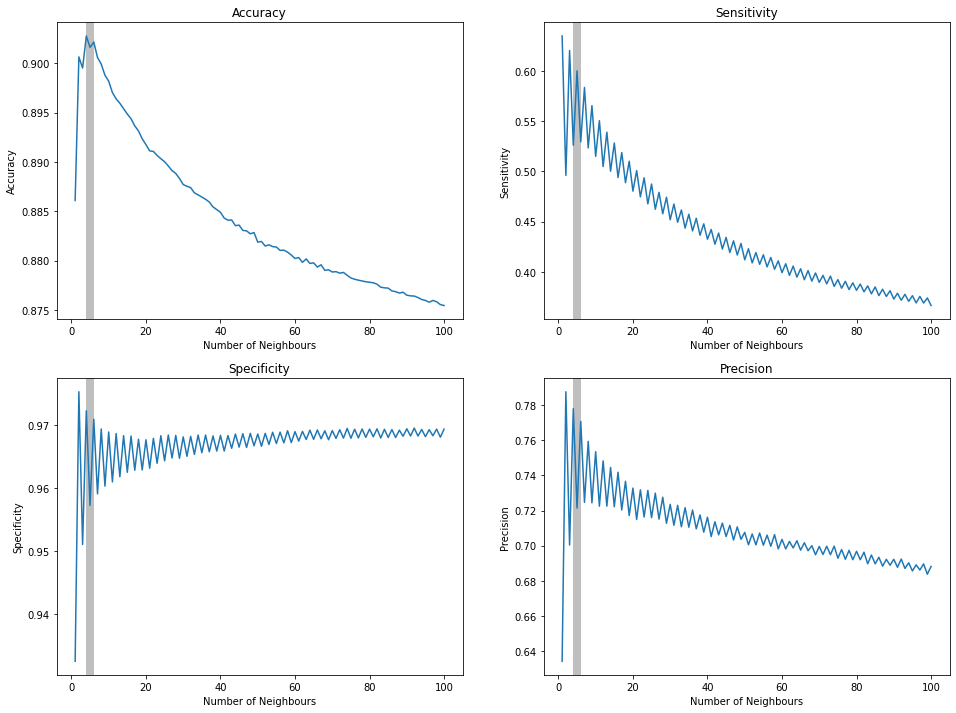

In [57]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for i, metric in enumerate(["accuracy", "sensitivity", "specificity", "precision"]):
    axes[i // 2, i % 2].plot(knn_df[metric])
    axes[i // 2, i % 2].set(
        title = metric.title(),
        xlabel = "Number of Neighbours",
        ylabel = metric.title()
    )
    
    axes[i // 2, i % 2].axvspan(4, 6, facecolor ='0.5', alpha = 0.5)

#plt.suptitle("K-Nearest Neighbours Variability Investigation")
# knn_df.accuracy.plot(
#     xlabel = "Number of Neighbours",
#     ylabel = "accuracy",
#     ax = ax
# )

In [51]:
knn_df.to_csv("knn.csv")

In [10]:
rf = cuml.ensemble.RandomForestClassifier()
cudf.DataFrame(train(rf))

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:567: UserWarning: To use pickling or GPU-based prediction first train using float32 data to fit the estimator
  ret_val = func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:586: UserWarning: GPU based predict only accepts np.float32 data. The model was trained on np.float64 data hence cannot use GPU-based prediction! 
Defaulting to CPU-based Prediction. 
To predict on float-64 data, set parameter predict_model = 'CPU'
  ret_val = func(*args, **kwargs)


,accuracy,tn,fp,fn,tp,roc_auc,sensitivity,specificity,precision
0,0.884331,113562,2769,13170,8297,0.681349,0.3865,0.976197,0.749774
